In [62]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from collections import defaultdict
from PIL import Image
import numpy as np
import cv2

# 1. Images Metadata

In [63]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정
traindata_dir = "./data/train"
traindata_info_file = "./data/train.csv"

# 테스트 데이터의 경로와 정보를 가진 파일의 경로를 설정
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"

In [64]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기
train_data = pd.read_csv(traindata_info_file)

# 테스트 데이터
test_data = pd.read_csv(testdata_info_file)

In [65]:
# 학습 데이터의 정보를 출력
train_info = train_data.info()
train_head = train_data.head()

train_info, train_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15021 entries, 0 to 15020
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  15021 non-null  object
 1   image_path  15021 non-null  object
 2   target      15021 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 352.2+ KB


(None,
   class_name                image_path  target
 0  n01872401  n01872401/sketch_50.JPEG      59
 1  n02417914  n02417914/sketch_11.JPEG     202
 2  n02106166   n02106166/sketch_3.JPEG     138
 3  n04235860   n04235860/sketch_2.JPEG     382
 4  n02056570  n02056570/sketch_40.JPEG      80)

주어진 테스트 데이터셋은 10014개의 항목과 3개의 컬럼으로 구성되어 있다.
1. class_name: 클래스 이름, string
2. image_path: 이미지 파일의 경로, string
3. target: 클래스를 의미하는 숫자아이디, integer

In [66]:
# 테스트 데이터의 정보를 출력.
test_info = test_data.info()
test_head = test_data.head()

test_info, test_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10014 entries, 0 to 10013
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10014 non-null  object
dtypes: object(1)
memory usage: 78.4+ KB


(None,
   image_path
 0     0.JPEG
 1     1.JPEG
 2     2.JPEG
 3     3.JPEG
 4     4.JPEG)

주어진 학습 데이터셋은 15021개의 항목과 1개의 컬럼으로 구성되어 있다.
1. image_path: 이미지 파일의 경로, string

In [67]:
# 데이터의 기본적인 통계 정보를 출력
data_description = train_data.describe(include='all')

# class_name의 unique한 값의 개수를 출력
unique_classes = train_data['class_name'].nunique()

# target의 unique한 값의 개수를 출력
unique_targets = train_data['target'].nunique()

data_description, unique_classes, unique_targets

(       class_name                image_path        target
 count       15021                     15021  15021.000000
 unique        500                     15021           NaN
 top     n04532106  n01872401/sketch_50.JPEG           NaN
 freq           31                         1           NaN
 mean          NaN                       NaN    249.989082
 std           NaN                       NaN    144.471752
 min           NaN                       NaN      0.000000
 25%           NaN                       NaN    125.000000
 50%           NaN                       NaN    250.000000
 75%           NaN                       NaN    375.000000
 max           NaN                       NaN    499.000000,
 500,
 500)

기본 통계
- 데이터셋에는 15,021개의 항목이 있음
- 500개의 고유한 클래스 이름과 15021개의 고유한 이미지 경로가 존재
- Target값은 0에서 499까지 500개의 값을 가지고 있음

C:\Users\HOME\AppData\Local\Temp\ipykernel_25164\1406674816.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_data['class_name'], order=train_data['class_name'].value_counts().index, palette='viridis')
C:\Users\HOME\AppData\Local\Temp\ipykernel_25164\1406674816.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(train_data['target'], bins=500, kde=False, palette='viridis')


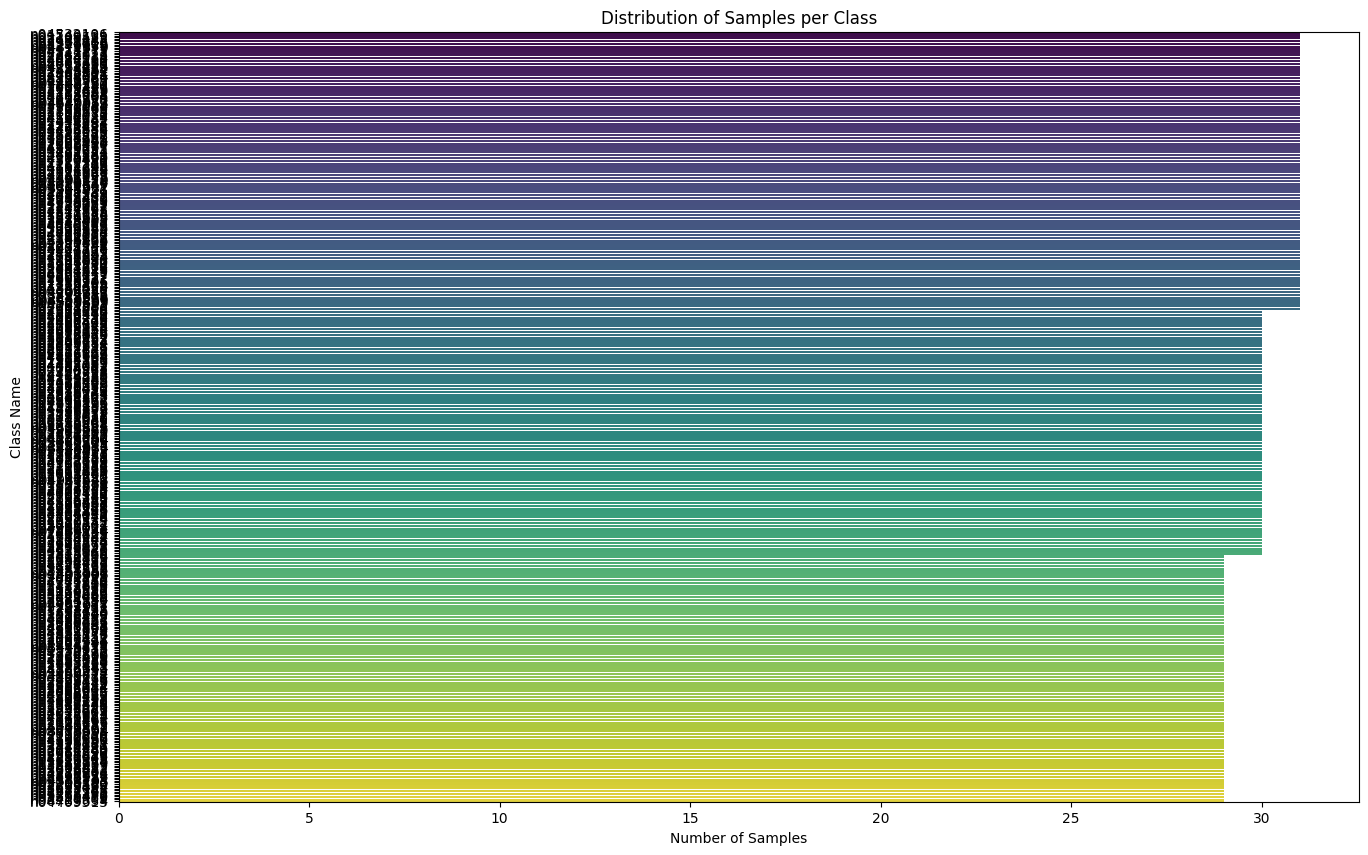

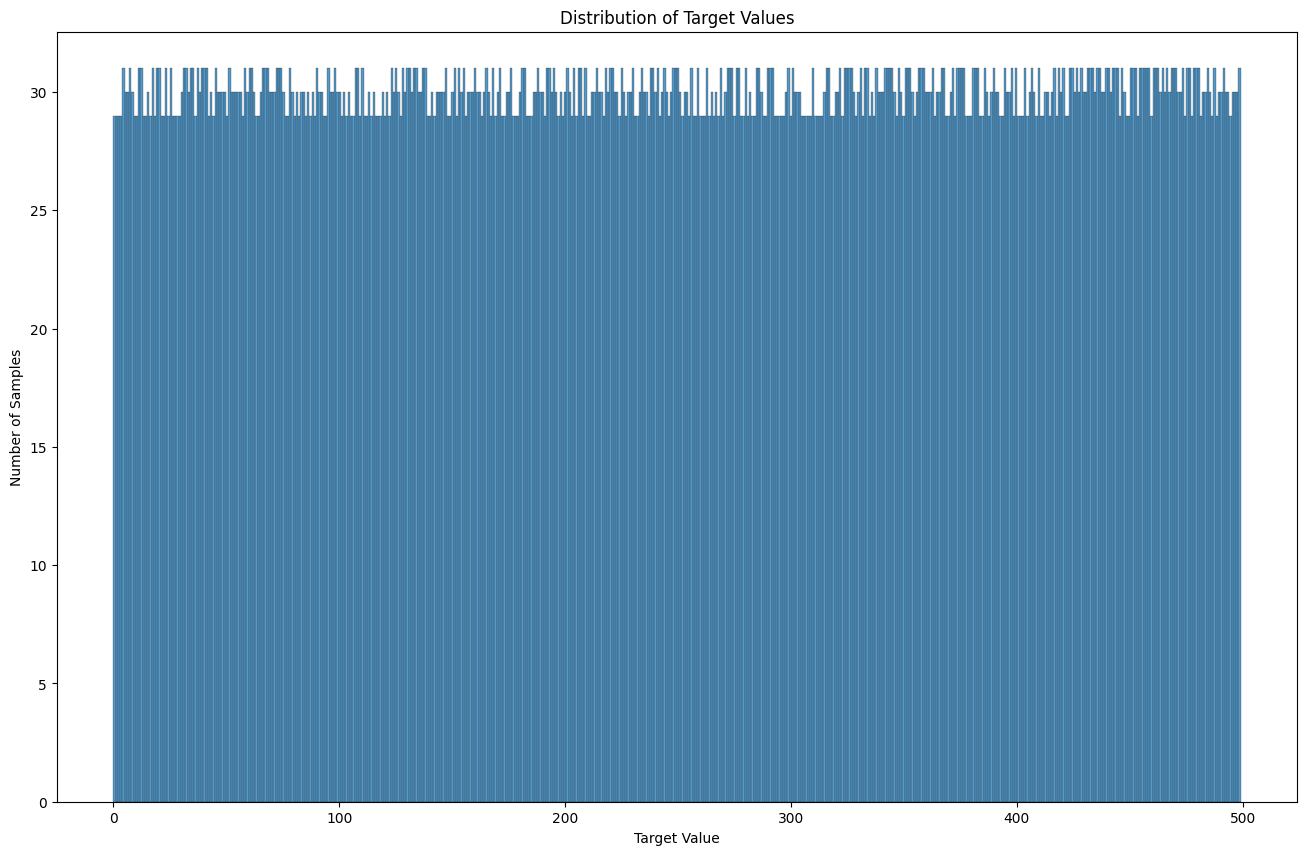

In [68]:
plt.figure(figsize=(16, 10))

# class_name별로 샘플의 개수를 출력
sns.countplot(y=train_data['class_name'], order=train_data['class_name'].value_counts().index, palette='viridis')
plt.title('Distribution of Samples per Class')
plt.xlabel('Number of Samples')
plt.ylabel('Class Name')

# target 값의 분포를 출력
plt.figure(figsize=(16, 10))
sns.histplot(train_data['target'], bins=500, kde=False, palette='viridis')
plt.title('Distribution of Target Values')
plt.xlabel('Target Value')
plt.ylabel('Number of Samples')

plt.show()


Class name 분포
- 대부분 29에서 31 사이의 값을 가지고 있음

Target 분포
- 대부분 29에서 31 사이의 값을 가지고 있음

데이터 셋 전반적으로 Class name, Target에 대해서 29~31개의 값을 가지고 있음.

# 2. Images - Exploration and processing

In [69]:
# glob을 이용하여 이미지 파일의 경로를 읽어옴
train_images = glob(traindata_dir + "/*/*")
test_images = glob(testdata_dir + "/*")
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of train images: 15021
Number of test images: 10014


## 2.1 Getting Image's statistics

In [70]:
# 이미지의 특징을 추출하는 함수
def extract_image_features(image_path):
    """
    Extracts features from an image.
    Args:
        image_path (str): Path to the image file.
    Returns:
        width (int): Width of the image.
        height (int): Height of the image.
        mode (str): Mode of the image.
        format (str): Format of the image.
        size (int): Size of the image.
        mean_red (float): Mean of red channel.
        mean_green (float): Mean of green channel.
        mean_blue (float): Mean of blue channel.
    """
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            width, height = img.size
            img_array = np.array(img)
            mean_red = np.mean(img_array[:, :, 0])
            mean_green = np.mean(img_array[:, :, 1])
            mean_blue = np.mean(img_array[:, :, 2])
            format = image_path.split('.')[-1].upper()
            return width, height, img.mode, format, os.path.getsize(image_path), mean_red, mean_green, mean_blue
    except Exception as e:
        return None, None, None, None, None, None, None, None

image_prop = defaultdict(list)

for i, path in enumerate(train_images):
    width, height, mode, format, size, mean_red, mean_green, mean_blue = extract_image_features(path)
    image_prop['height'].append(height)
    image_prop['width'].append(width)
    image_prop['mode'].append(mode)
    image_prop['format'].append(format)
    image_prop['size'].append(round(size / 1e6, 2) if size else None)
    image_prop['mean_red'].append(mean_red)
    image_prop['mean_green'].append(mean_green)
    image_prop['mean_blue'].append(mean_blue)
    image_prop['path'].append(path)
    image_prop['image_path'].append(path.split('/')[-2] + "/" + path.split('/')[-1])


image_data = pd.DataFrame(image_prop)
image_data['img_aspect_ratio'] = image_data['width'] / image_data['height']
train_data['image_path'] = 'data/train\\' + train_data['image_path'].str.replace('/','\\')
image_data = image_data.merge(train_data, on='image_path')
image_data.sort_values(by='target', inplace=True)


In [72]:
image_data.head()

,height,width,mode,format,size,mean_red,mean_green,mean_blue,path,image_path,img_aspect_ratio,class_name,target
0,800,800,RGB,JPEG,0.08,242.660972,242.638962,242.737358,./data/train\n01443537\sketch_0.JPEG,data/train\n01443537\sketch_0.JPEG,1.000000,n01443537,0
28,447,553,RGB,JPEG,0.05,237.306188,236.565138,236.498012,./data/train\n01443537\sketch_9.JPEG,data/train\n01443537\sketch_9.JPEG,1.237136,n01443537,0
27,800,616,RGB,JPEG,0.03,240.679957,240.679957,240.679957,./data/train\n01443537\sketch_7.JPEG,data/train\n01443537\sketch_7.JPEG,0.770000,n01443537,0
26,470,450,RGB,JPEG,0.05,234.881868,234.881868,234.881868,./data/train\n01443537\sketch_6.JPEG,data/train\n01443537\sketch_6.JPEG,0.957447,n01443537,0
25,800,800,RGB,JPEG,0.08,237.315462,236.517811,237.136986,./data/train\n01443537\sketch_49.JPEG,data/train\n01443537\sketch_49.JPEG,1.000000,n01443537,0


### 2.1.1 이미지 파일크기 분석

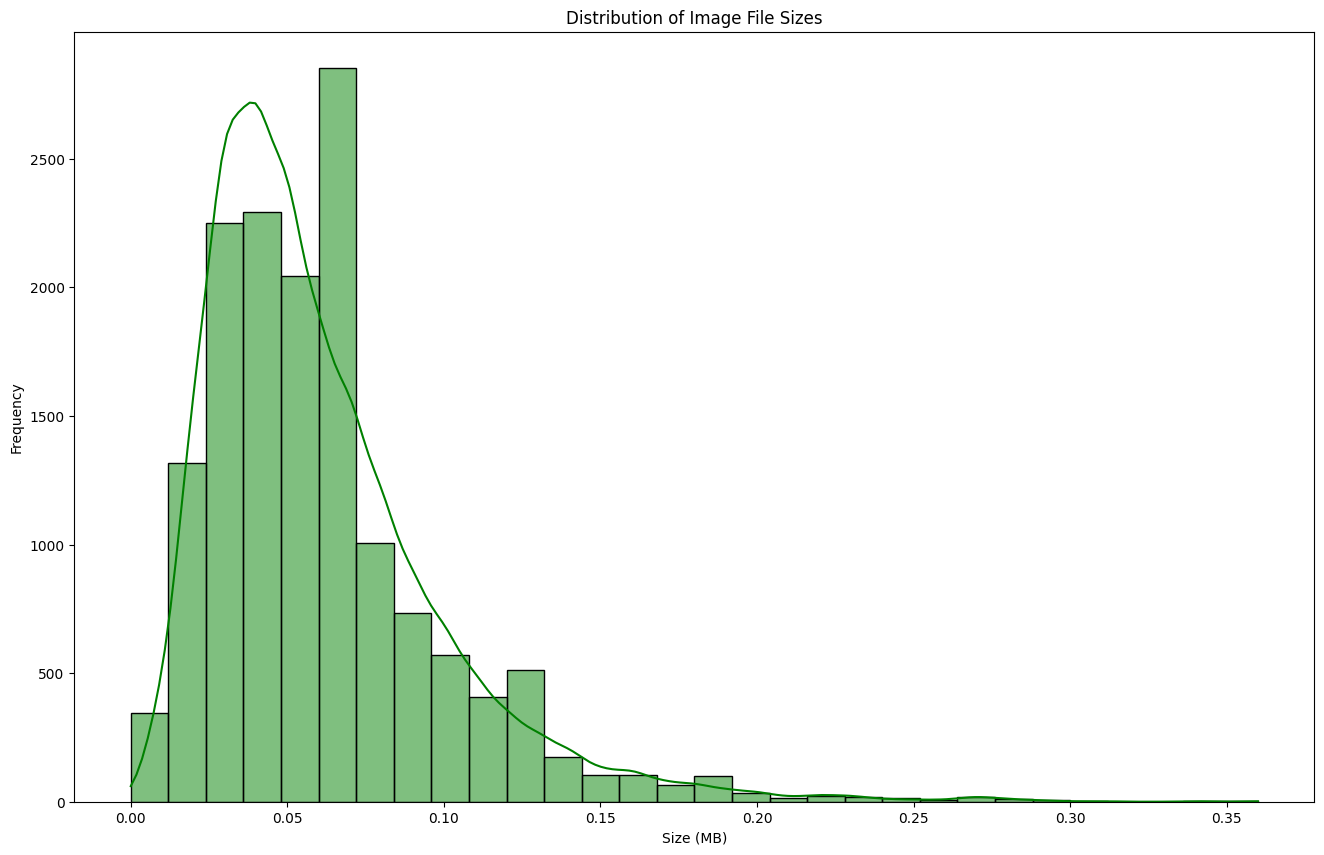

In [73]:
plt.figure(figsize=(16, 10))

# 이미지 파일의 크기 분포를 출력
sns.histplot(image_data['size'], bins=30, kde=True, color='green')
plt.title('Distribution of Image File Sizes')
plt.xlabel('Size (MB)')
plt.ylabel('Frequency')

plt.show()

이미지 파일 크기 분포
- 대부분 이미지 파일 크기는 0.05 ~ 0.1 MB 사이에 분포

### 2.1.2 이미지 파일 Resolution 분석

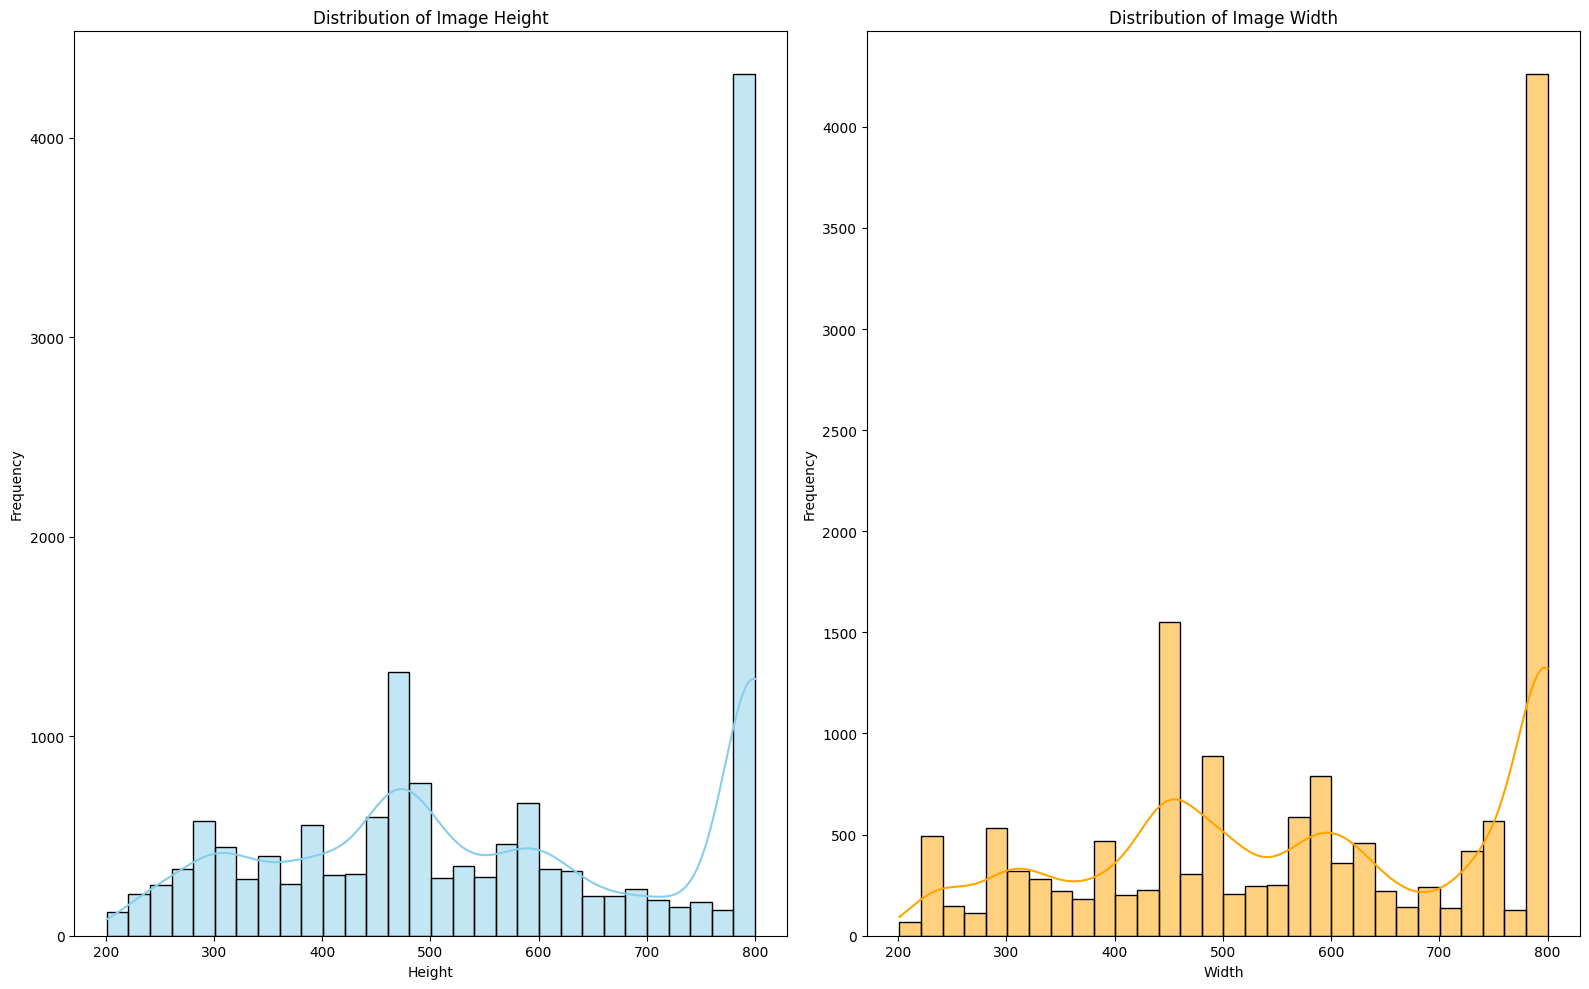

In [74]:
plt.figure(figsize=(16, 10))
# Image height의 분포를 출력
plt.subplot(1, 2, 1)
sns.histplot(image_data['height'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.ylabel('Frequency')

# Image width의 분포를 출력
plt.subplot(1, 2, 2)
sns.histplot(image_data['width'], bins=30, kde=True, color='orange')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

이미지의 높이와 너비 분포
- 이미지 높이: 대부분 이미지 높이는 400에서 800 픽셀 사이에 분포
- 이미지 너비: 대부분 이미지 너비는 400에서 800 픽셀 사이에 분포

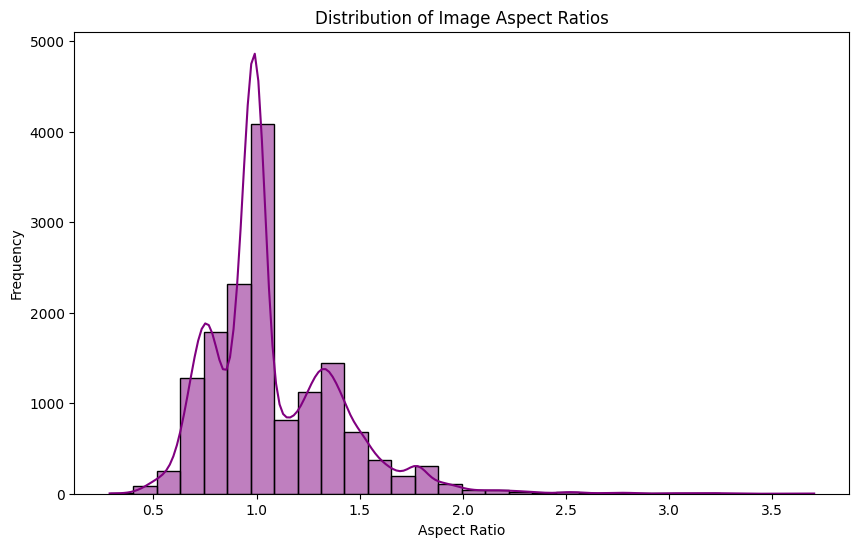

In [75]:
plt.figure(figsize=(10, 6))

# 이미지의 가로 세로 비율을 출력
sns.histplot(image_data['img_aspect_ratio'], bins=30, kde=True, color='purple')
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')

plt.show()


가로세로 비율 분포
- 대부분의 이미지 가로세로 비율을 0.8에서 1.2사이에 분포

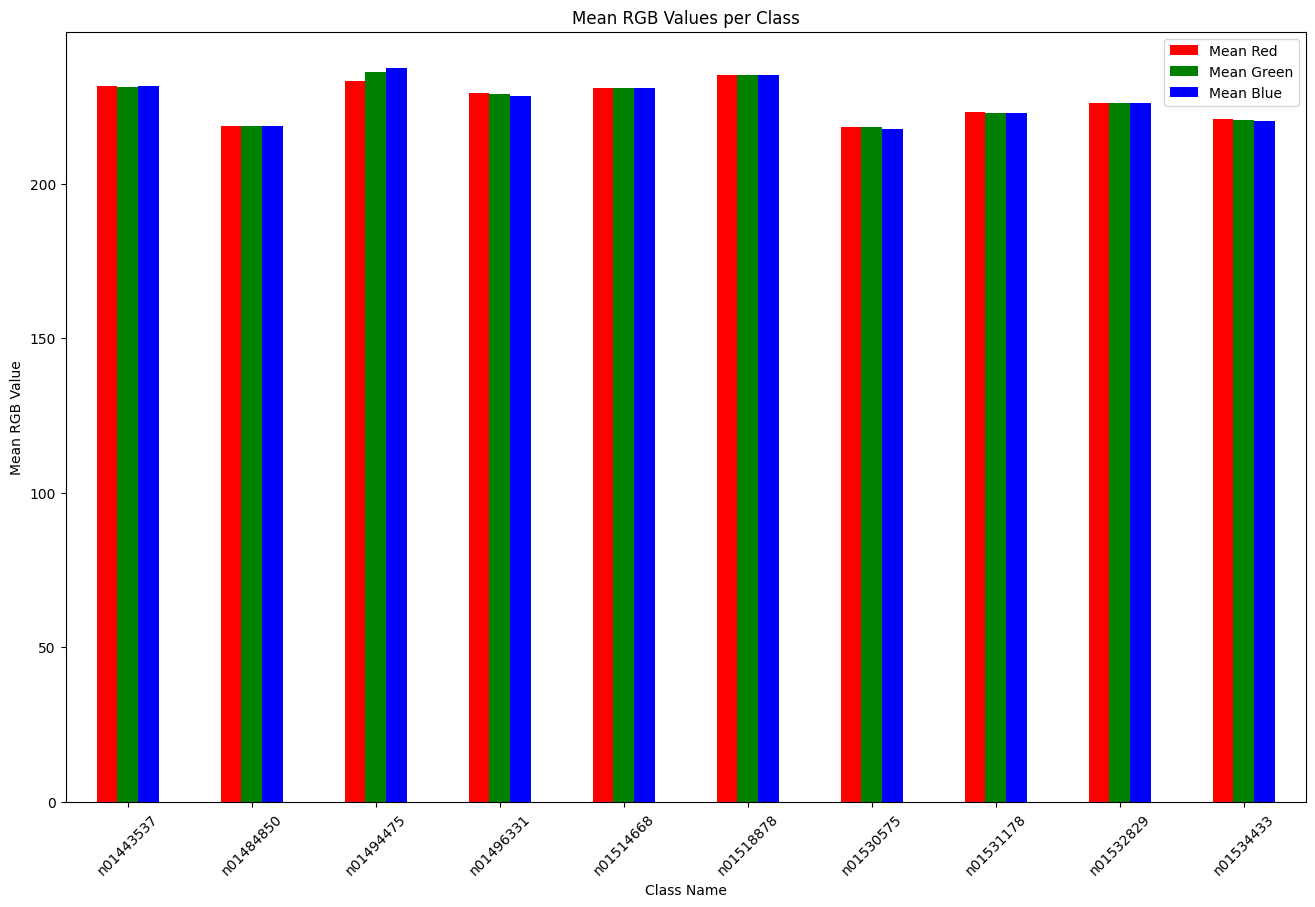

In [76]:
# 10개의 샘플 선택
sample_classes = image_data['class_name'].unique()[:10]

# 각 클래스별로 RGB값의 평균을 계산
mean_rgb_per_class = image_data[image_data['class_name'].isin(sample_classes)].groupby('class_name')[['mean_red', 'mean_green', 'mean_blue']].mean()

# 클래스별로 RGB값의 평균을 출력
mean_rgb_per_class.plot(kind='bar', figsize=(16, 10), color=['red', 'green', 'blue'])
plt.title('Mean RGB Values per Class')
plt.xlabel('Class Name')
plt.ylabel('Mean RGB Value')
plt.xticks(rotation=45)
plt.legend(['Mean Red', 'Mean Green', 'Mean Blue'])
plt.show()


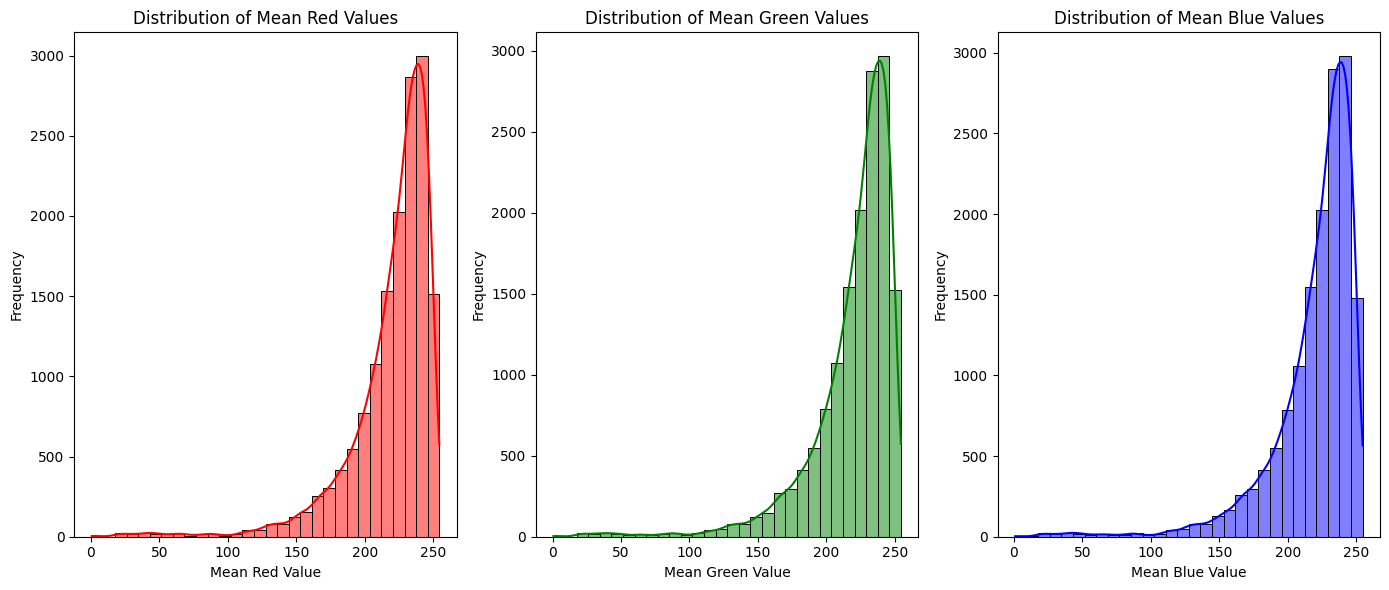

In [78]:
# RGB값의 평균 분포를 출력
plt.figure(figsize=(14, 6))

# mean_red 값의 분포를 출력
plt.subplot(1, 3, 1)
sns.histplot(image_data['mean_red'], bins=30, kde=True, color='red')
plt.title('Distribution of Mean Red Values')
plt.xlabel('Mean Red Value')
plt.ylabel('Frequency')

# mean_green 값의 분포를 출력
plt.subplot(1, 3, 2)
sns.histplot(image_data['mean_green'], bins=30, kde=True, color='green')
plt.title('Distribution of Mean Green Values')
plt.xlabel('Mean Green Value')
plt.ylabel('Frequency')

# mean_blue 값의 분포를 출력
plt.subplot(1, 3, 3)
sns.histplot(image_data['mean_blue'], bins=30, kde=True, color='blue')
plt.title('Distribution of Mean Blue Values')
plt.xlabel('Mean Blue Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


색상 분포 분석
- 대부분 Red, Green, Blue값이 200~250사이에 분포
- 전박적으로 이미지의 밝기와 채도가 높은 편

C:\Users\HOME\AppData\Local\Temp\ipykernel_25164\2640141684.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='height', y='class_name', data=class_size_stats.sort_values(by='height', ascending=False), palette='viridis')
C:\Users\HOME\AppData\Local\Temp\ipykernel_25164\2640141684.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='width', y='class_name', data=class_size_stats.sort_values(by='width', ascending=False), palette='viridis')


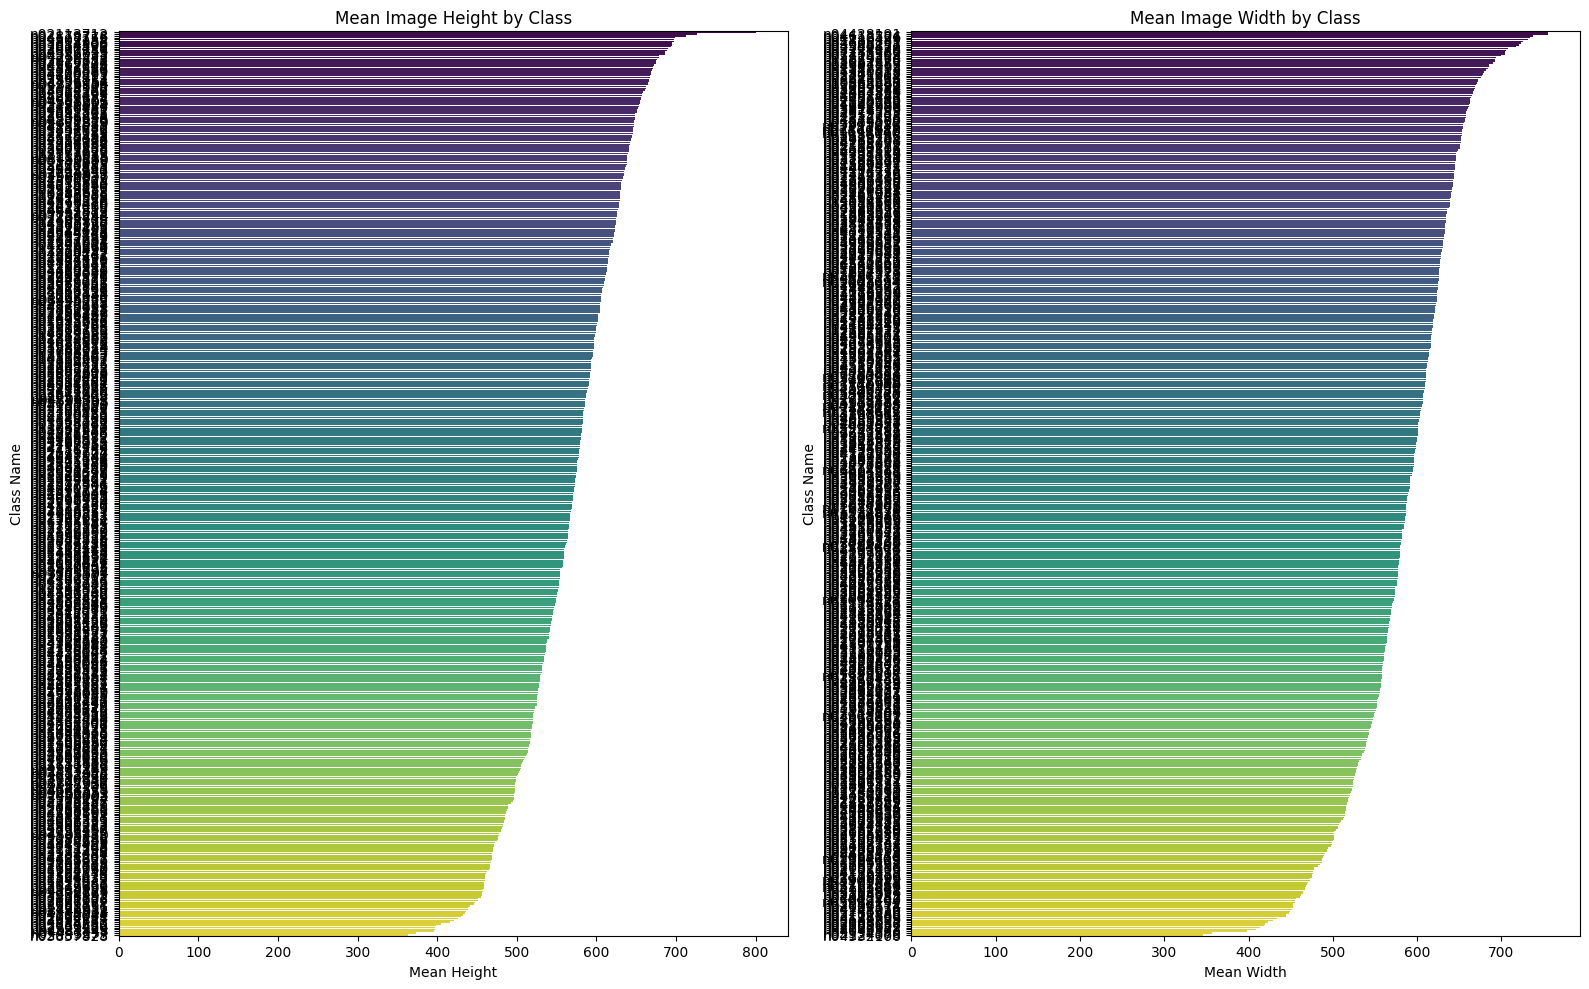

In [79]:
# 각 클래스별로 이미지의 평균 높이와 너비를 계산
class_size_stats = image_data.groupby('class_name')[['height', 'width']].mean().reset_index()

# 각 클래스별로 이미지의 평균 높이와 너비를 출력
plt.figure(figsize=(16, 10))

# 클래스별 이미지의 평균 높이를 출력
plt.subplot(1, 2, 1)
sns.barplot(x='height', y='class_name', data=class_size_stats.sort_values(by='height', ascending=False), palette='viridis')
plt.title('Mean Image Height by Class')
plt.xlabel('Mean Height')
plt.ylabel('Class Name')

# 클래스별 이미지의 평균 너비를 출력
plt.subplot(1, 2, 2)
sns.barplot(x='width', y='class_name', data=class_size_stats.sort_values(by='width', ascending=False), palette='viridis')
plt.title('Mean Image Width by Class')
plt.xlabel('Mean Width')
plt.ylabel('Class Name')

plt.tight_layout()
plt.show()

클래스별 이미지 크기 분포
- 대부분 클래스는 300에서 800 픽셀 사이의 평균 높이를 가지고 있음
- 대부분 클래스느 300에서 800 픽셀 사이의 평균 너비를 가지고 있음

C:\Users\HOME\AppData\Local\Temp\ipykernel_25164\3931341571.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='mean_red', data=image_data, palette='Reds')
C:\Users\HOME\AppData\Local\Temp\ipykernel_25164\3931341571.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='mean_green', data=image_data, palette='Greens')
C:\Users\HOME\AppData\Local\Temp\ipykernel_25164\3931341571.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='mean_blue', data=image_data, palette='Blues')


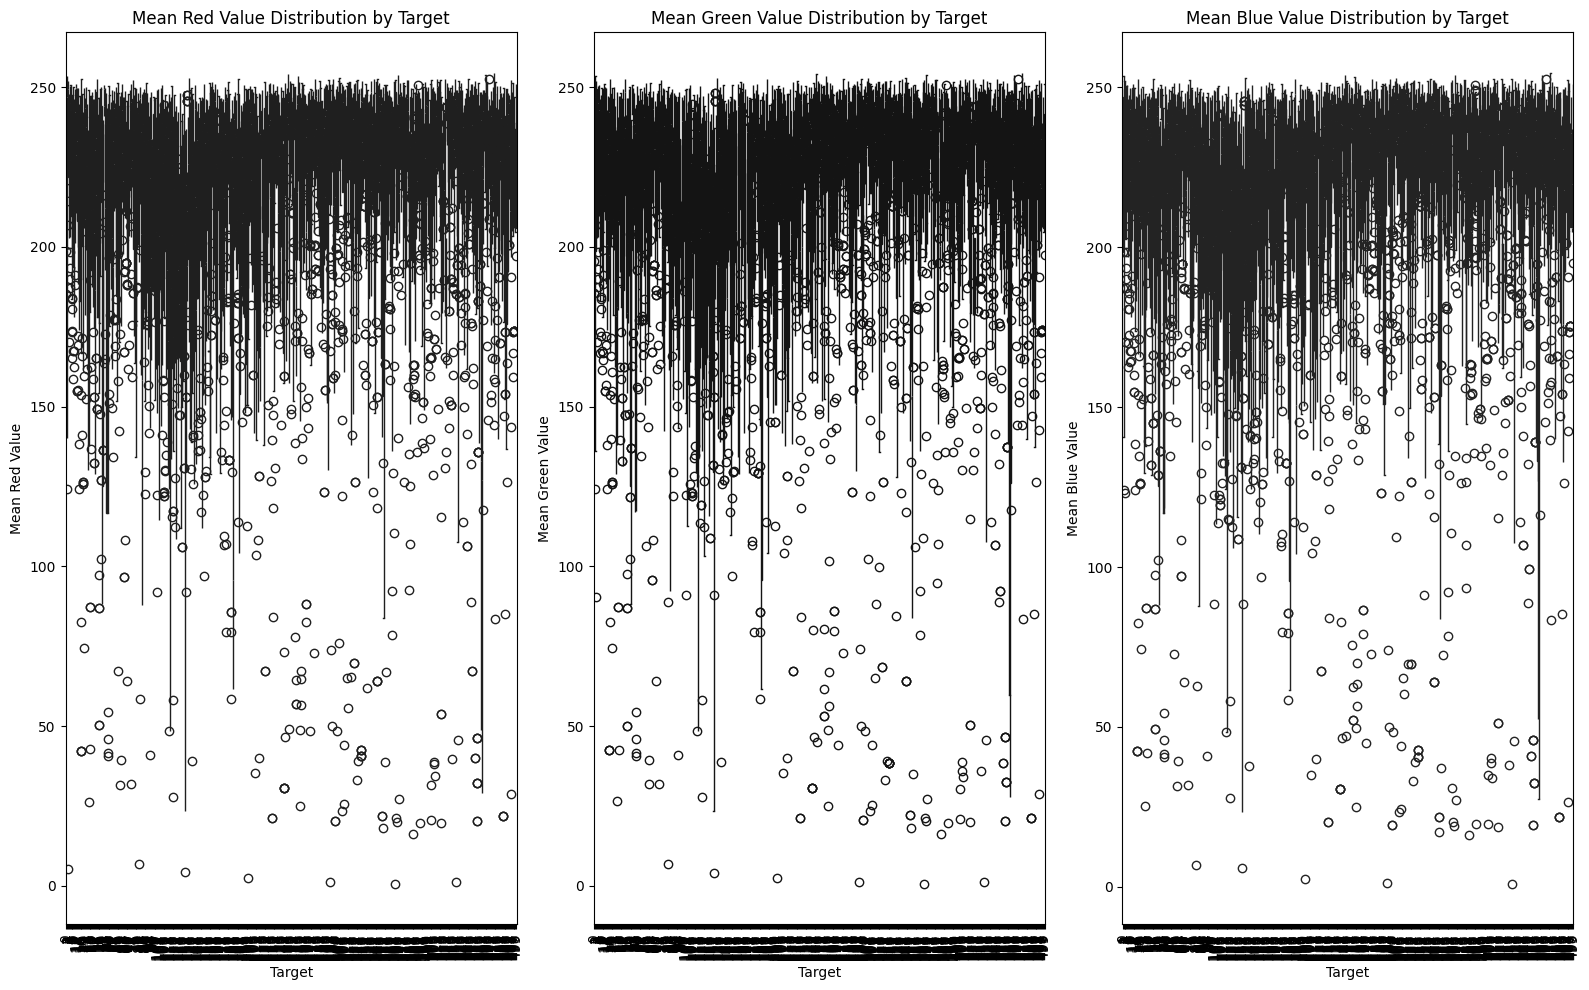

In [80]:
plt.figure(figsize=(16, 10))

# mean_red 값의 분포를 출력
plt.subplot(1, 3, 1)
sns.boxplot(x='target', y='mean_red', data=image_data, palette='Reds')
plt.title('Mean Red Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Red Value')
plt.xticks(rotation=90)

# mean_green 값의 분포를 출력
plt.subplot(1, 3, 2)
sns.boxplot(x='target', y='mean_green', data=image_data, palette='Greens')
plt.title('Mean Green Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Green Value')
plt.xticks(rotation=90)

# mean_blue 값의 분포를 출력
plt.subplot(1, 3, 3)
sns.boxplot(x='target', y='mean_blue', data=image_data, palette='Blues')
plt.title('Mean Blue Value Distribution by Target')
plt.xlabel('Target')
plt.ylabel('Mean Blue Value')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


클래스별 이미지 색상의 분포
- 대부분 Red, Green, Blue 값은 200에서 250 사이에 분포

## 2.2 Displaying images

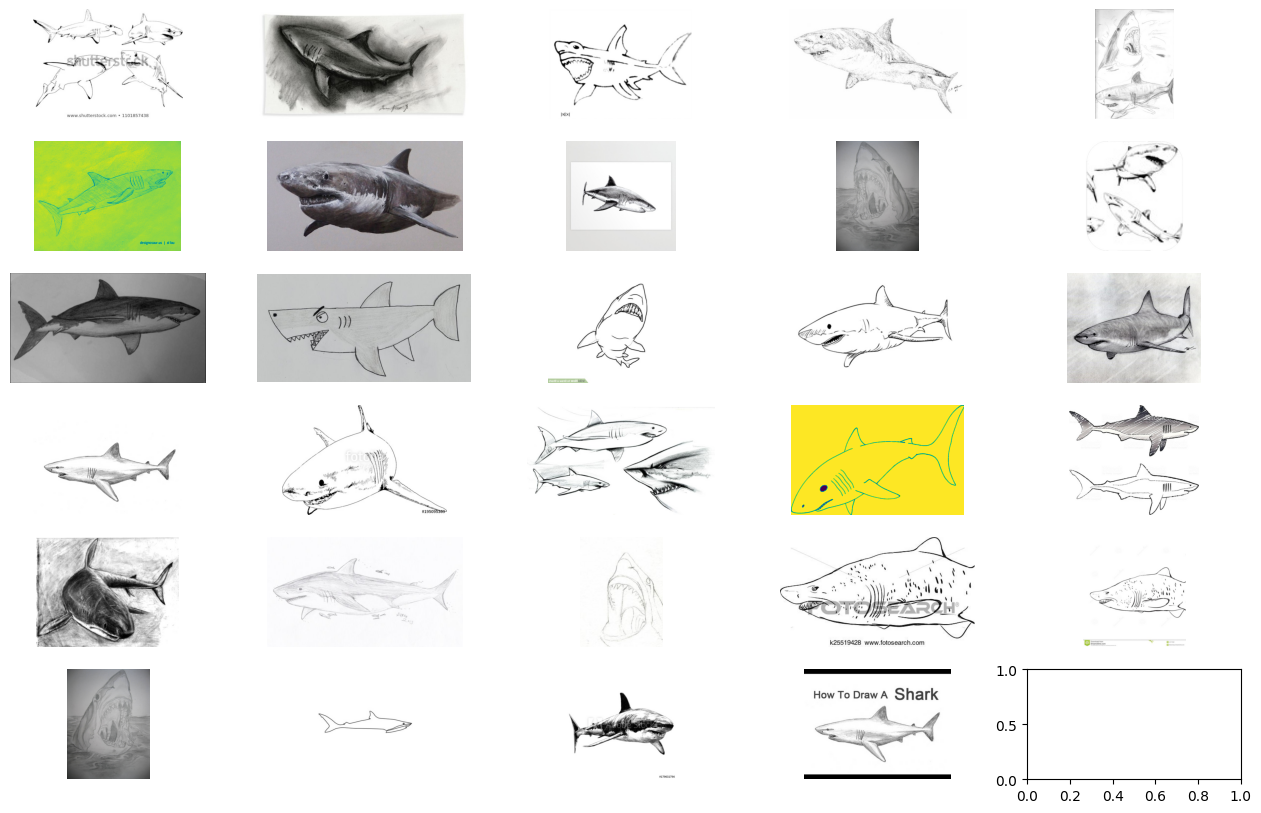

In [90]:
# 같은 target을 가진 이미지 전체 출력
def display_images(data, target):
    len_data = len(data[data['target'] == target])
    fig, axs = plt.subplots((len_data // 5)+1, 5, figsize=(16, 10))
    images = data[data['target'] == target]['path'].values
    for i, path in enumerate(images):
        img = Image.open(path)
        ax = axs[i // 5, i % 5]  # Use double indexing for 2D subplots
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# target이 1인 이미지 출력
display_images(image_data, target=1)


In [91]:
# class별 사진 요약본 저장
def save_individual_target_images(data, target_range):
    # 저장할 폴더 생성
    base_dir = './data'
    output_dir = os.path.join(base_dir, 'train_image_by_class')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for target in target_range:
        # target에 해당하는 이미지 수집
        len_data = len(data[data['target'] == target])
        if len_data == 0:
            print(f"No images for target {target}")
            continue
        
        fig, axs = plt.subplots((len_data // 5) + 1, 5, figsize=(16, 10))
        images = data[data['target'] == target]['path'].values
        for i, path in enumerate(images):
            img = Image.open(path)
            ax = axs[i // 5, i % 5]  # Use double indexing for 2D subplots
            ax.imshow(img)
            ax.axis('off')
        
        # 파일로 저장
        output_path = os.path.join(output_dir, f'target_{target}_images.png')
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()
        print(f"Saved images for target {target} to {output_path}")

# target 0부터 499까지의 이미지들을 각각 하나의 파일로 저장
save_individual_target_images(image_data, range(500))

Saved images for target 0 to ./data\train_image_by_class\target_0_images.png
Saved images for target 1 to ./data\train_image_by_class\target_1_images.png
Saved images for target 2 to ./data\train_image_by_class\target_2_images.png
Saved images for target 3 to ./data\train_image_by_class\target_3_images.png
Saved images for target 4 to ./data\train_image_by_class\target_4_images.png
Saved images for target 5 to ./data\train_image_by_class\target_5_images.png
Saved images for target 6 to ./data\train_image_by_class\target_6_images.png
Saved images for target 7 to ./data\train_image_by_class\target_7_images.png
Saved images for target 8 to ./data\train_image_by_class\target_8_images.png
Saved images for target 9 to ./data\train_image_by_class\target_9_images.png
Saved images for target 10 to ./data\train_image_by_class\target_10_images.png
Saved images for target 11 to ./data\train_image_by_class\target_11_images.png
Saved images for target 12 to ./data\train_image_by_class\target_12_imag

### 2.2.1 Displying random images using PIL

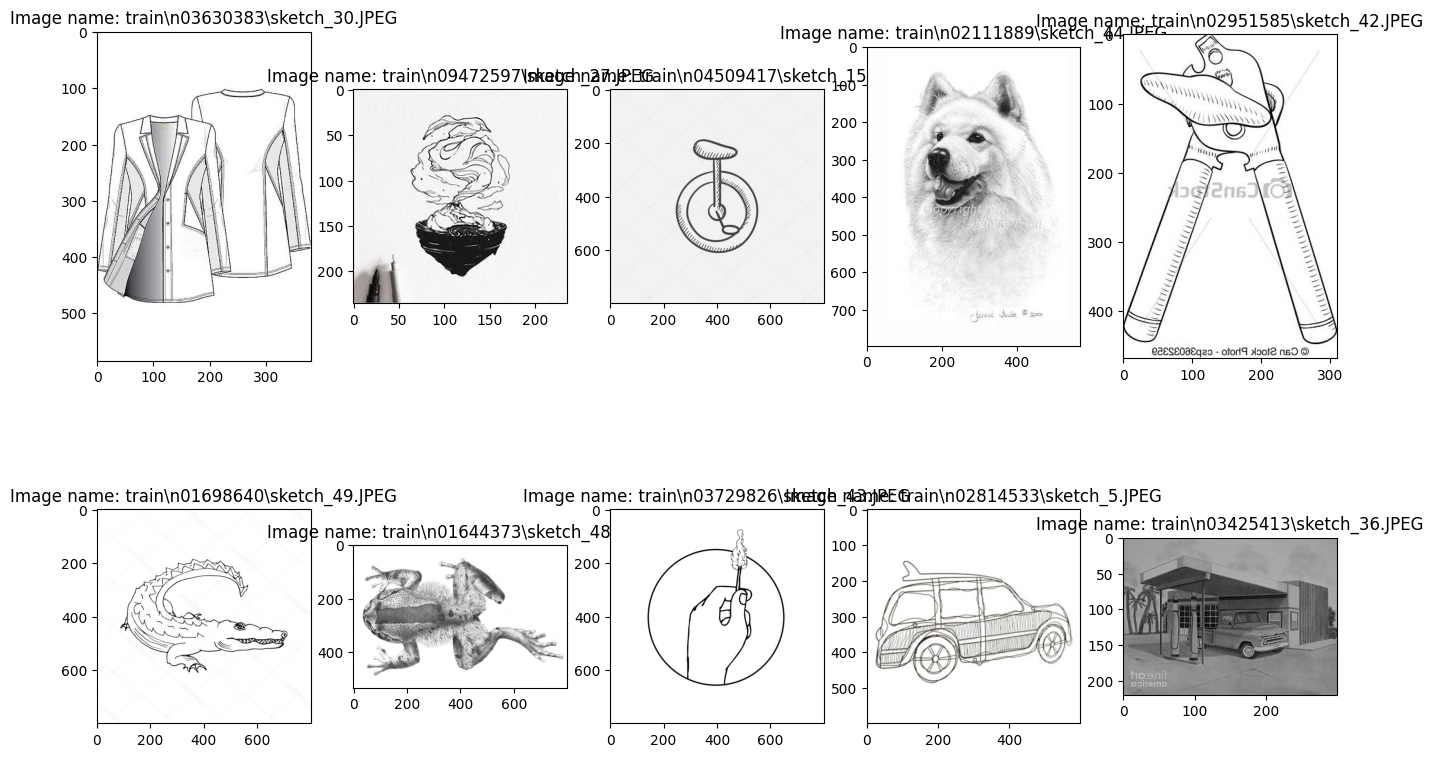

In [94]:
# 이미지를 랜덤으로 5개 출력
plt.style.use('default')
fig, axex = plt.subplots(2, 5, figsize=(16, 10))
for ax in axex.reshape(-1):
    img_path = np.random.choice(train_images)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Image name: {img_path.split('/')[-1]}")
plt.show()

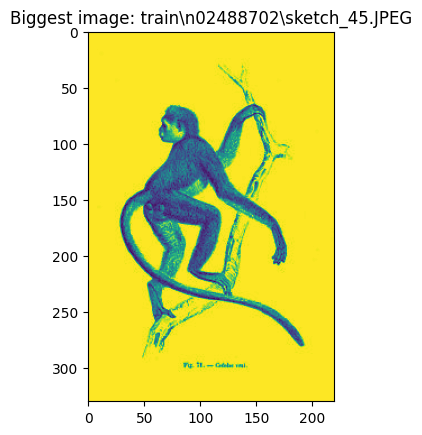

In [108]:
# 가장 큰 이미지를 출력
biggest_img_path = image_data.iloc[image_data['size'].idxmax(),:]['path']

img = Image.open(biggest_img_path)
plt.title(f"Biggest image: {biggest_img_path.split('/')[-1]}")
plt.imshow(img)
del img

In [110]:
# 4개의 작은 이미지를 출력
smallest_img_paths = image_data.nsmallest(4, 'size')['path']
smallest_img_paths.values

array(['./data/train\\n04127249\\sketch_9.JPEG',
       './data/train\\n01484850\\sketch_0.JPEG',
       './data/train\\n01484850\\sketch_34.JPEG',
       './data/train\\n01494475\\sketch_33.JPEG'], dtype=object)

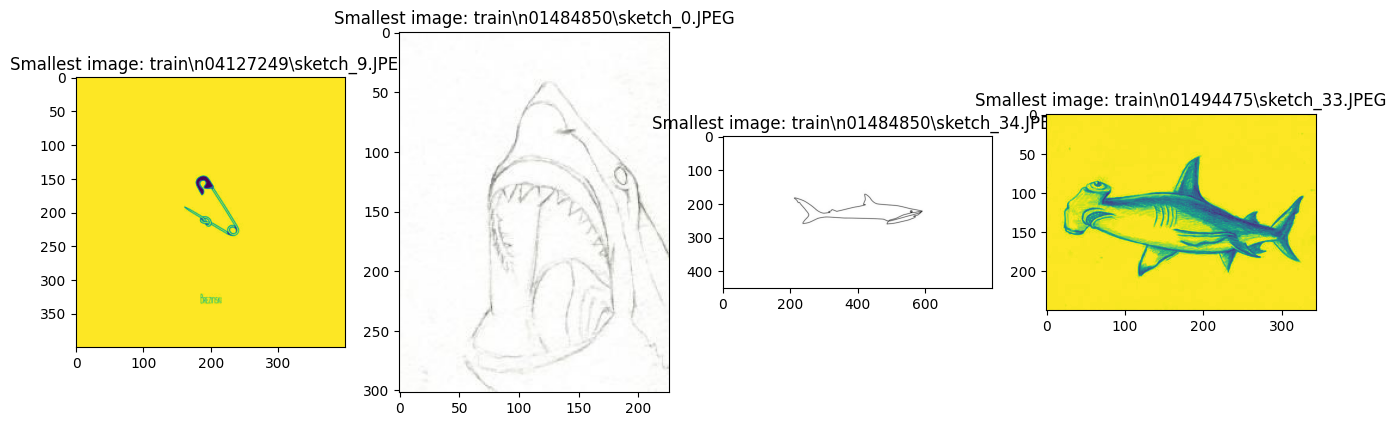

In [113]:
import matplotlib.image as mpimg

# 4개의 작은 이미지를 출력
fig, axes = plt.subplots(1, 4, figsize=(16, 10))
for i, ax in enumerate(axes.reshape(-1)):
    img = mpimg.imread(smallest_img_paths.values[i])
    ax.title.set_text(f"Smallest image: {smallest_img_paths.values[i].split('/')[-1]}")
    ax.imshow(img)
plt.show()

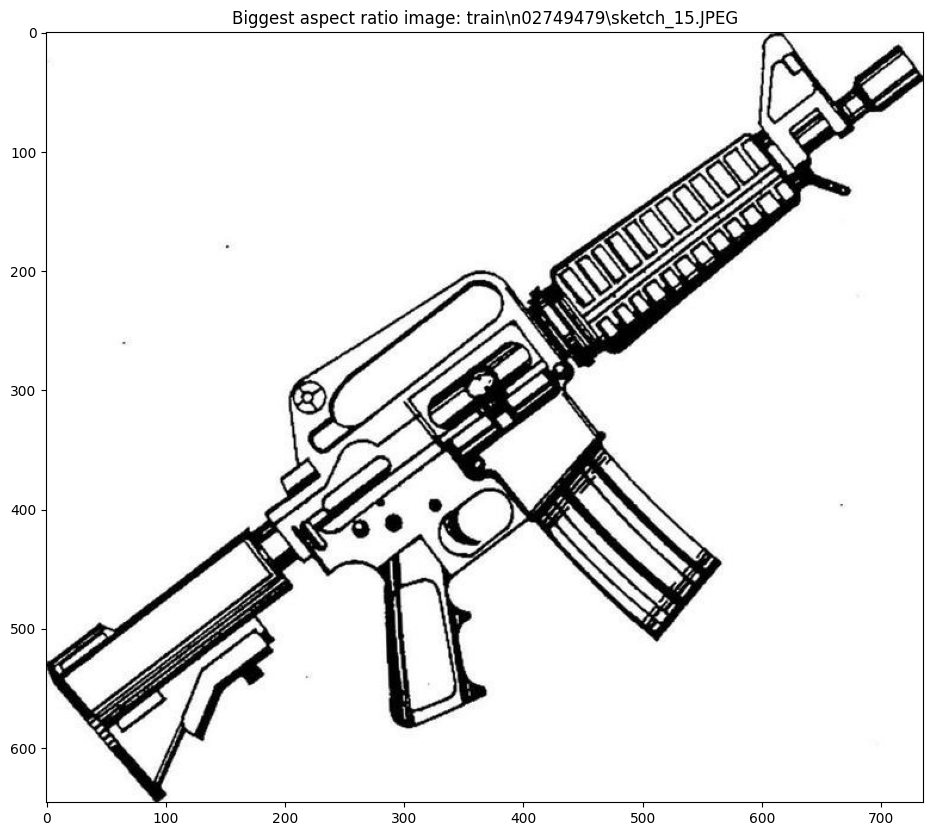

In [116]:
# 이미지의 종횡비가 가장 큰 이미지를 출력
biggest_aspect_ratio_img_path = image_data.iloc[image_data['img_aspect_ratio'].idxmax(),:]['path']

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
img = Image.open(biggest_aspect_ratio_img_path)
plt.title(f"Biggest aspect ratio image: {biggest_aspect_ratio_img_path.split('/')[-1]}")
plt.imshow(img)

### 2.2.2 Diplaying, resizing and manipulation using CV2

In [117]:
img_path = train_images[10]
selected_img = image_data[image_data['path'] == img_path]
selected_img

,height,width,mode,format,size,mean_red,mean_green,mean_blue,path,image_path,img_aspect_ratio,class_name,target
10,700,700,RGB,JPEG,0.07,235.5206,235.549143,235.100276,./data/train\n01443537\sketch_26.JPEG,data/train\n01443537\sketch_26.JPEG,1.0,n01443537,0


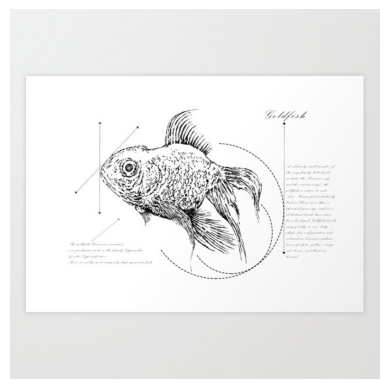

In [119]:
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

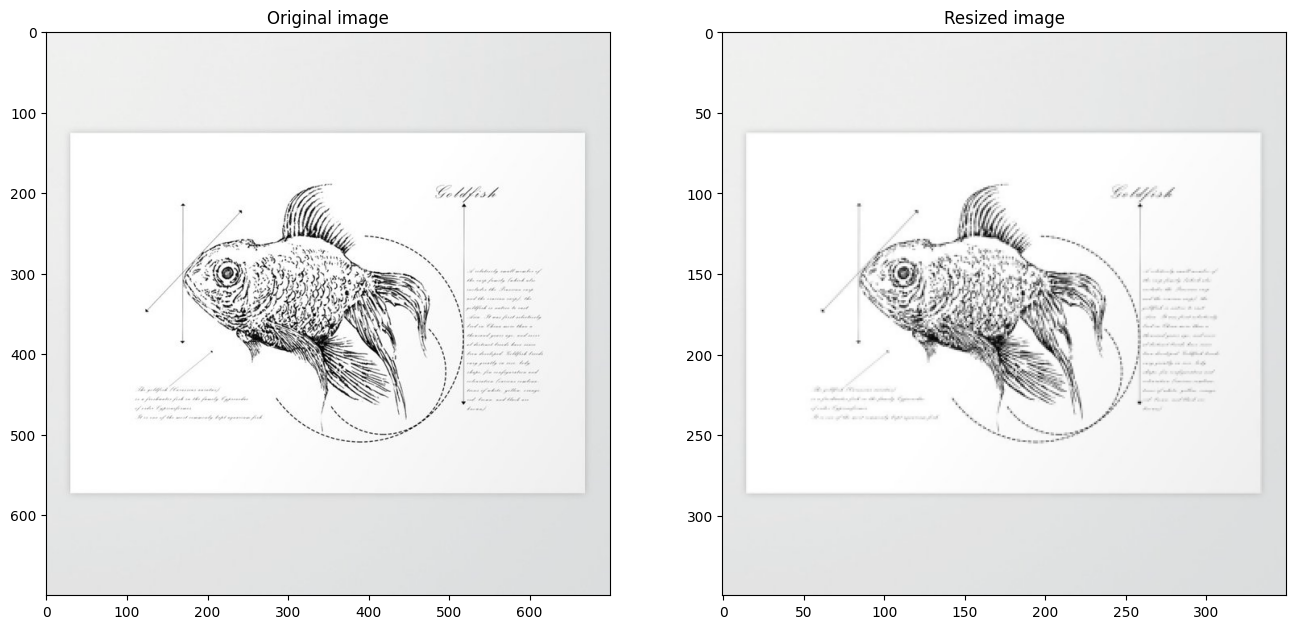

In [121]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
resized_img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)

fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(img)
ax[0].set_title("Original image")
ax[1].imshow(resized_img)
ax[1].set_title("Resized image")
plt.show()